In [ ]:
""""""

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
%matplotlib inline
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


Using TensorFlow backend.


In [2]:

# load dataset
dataset = read_csv('AL100_final.csv', parse_dates=['Date'], index_col='Date')
dataset = dataset[['Flow','TimePeriod','AverageJT','AverageSpeed','DataQuality','LinkLength']]
dataset.dropna(inplace=True,axis=0,how='any')
values = dataset.values
dataset.head()

,Flow,TimePeriod,AverageJT,AverageSpeed,DataQuality,LinkLength
Date,,,,,,
2015-03-01,31.0,0,138.25,117.4375,1,4.511719
2015-03-01,32.5,1,138.25,117.4375,1,4.511719
2015-03-01,26.5,2,138.25,117.4375,1,4.511719
2015-03-01,23.5,3,138.25,117.4375,1,4.511719
2015-03-01,18.0,4,138.25,117.4375,1,4.511719


In [ ]:

# integer encode direction # it is not neede as we are not using any labels here 
######encoder = LabelEncoder()
######values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [ ]:
# specify the number of lag hours
n_hours = 96 #Days is used to Decide input steps it should be decided on input we have 96 input for a day
n_features = 6 #
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)


In [6]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


((8760, 18), 8760, (8760,))
((8760, 3, 6), (8760,), (1656349, 3, 6), (1656349,))


In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam',metrics=['mse', 'accuracy'])
# fit network
#history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 8760 samples, validate on 1656349 samples
Epoch 1/50
8760/8760 [==============================] - 30s 3ms/step - loss: 0.0325 - mean_squared_error: 0.0019 - acc: 0.0000e+00 - val_loss: 0.0233 - val_mean_squared_error: 0.0010 - val_acc: 1.2075e-05
Epoch 2/50
8760/8760 [==============================] - 27s 3ms/step - loss: 0.0134 - mean_squared_error: 3.8841e-04 - acc: 0.0000e+00 - val_loss: 0.0200 - val_mean_squared_error: 8.3687e-04 - val_acc: 1.2075e-05
Epoch 3/50
8760/8760 [==============================] - 27s 3ms/step - loss: 0.0117 - mean_squared_error: 3.2258e-04 - acc: 0.0000e+00 - val_loss: 0.0195 - val_mean_squared_error: 8.3487e-04 - val_acc: 1.2075e-05
Epoch 4/50
8760/8760 [==============================] - 27s 3ms/step - loss: 0.0116 - mean_squared_error: 3.0748e-04 - acc: 0.0000e+00 - val_loss: 0.0188 - val_mean_squared_error: 7.9872e-04 - val_acc: 1.2075e-05
Epoch 5/50
8760/8760 [==============================] - 27s 3ms/step - loss: 0.0112 - mean_squared_error:

In [8]:
#dataset = dataset.drop(["LinkRef","Unnamed: 0"],axis=1)
#dataset.to_csv("AL100_final.csv")

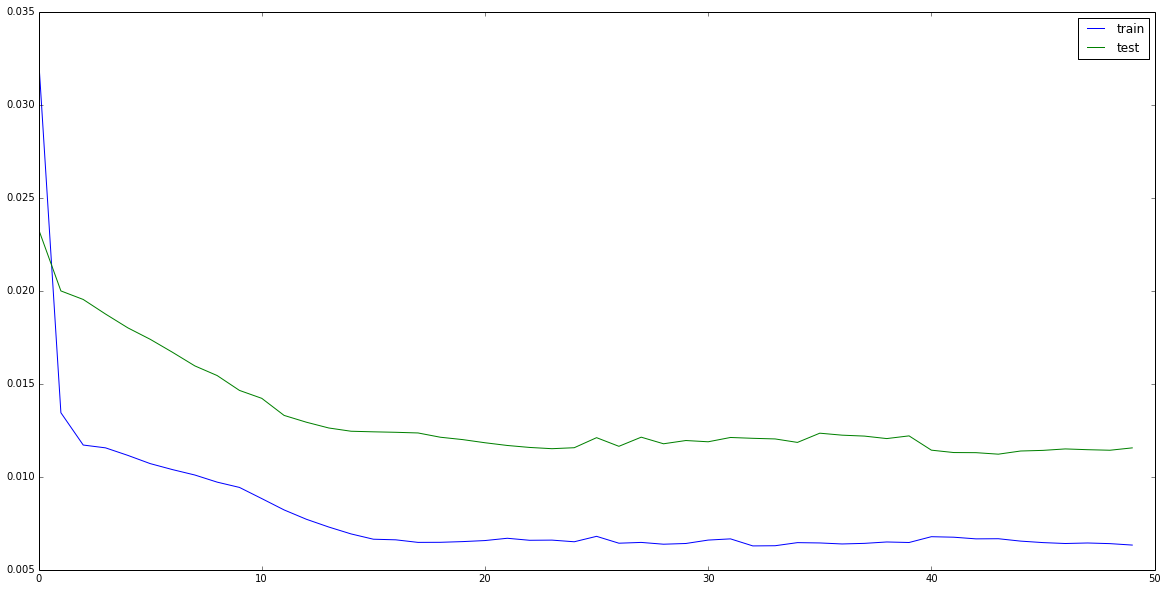

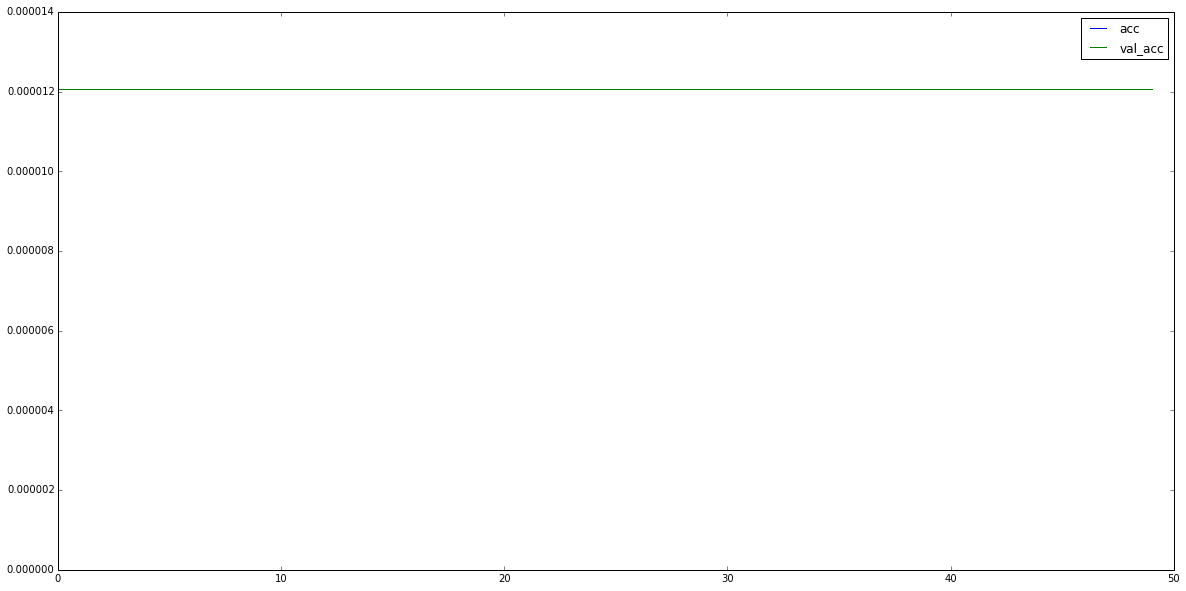

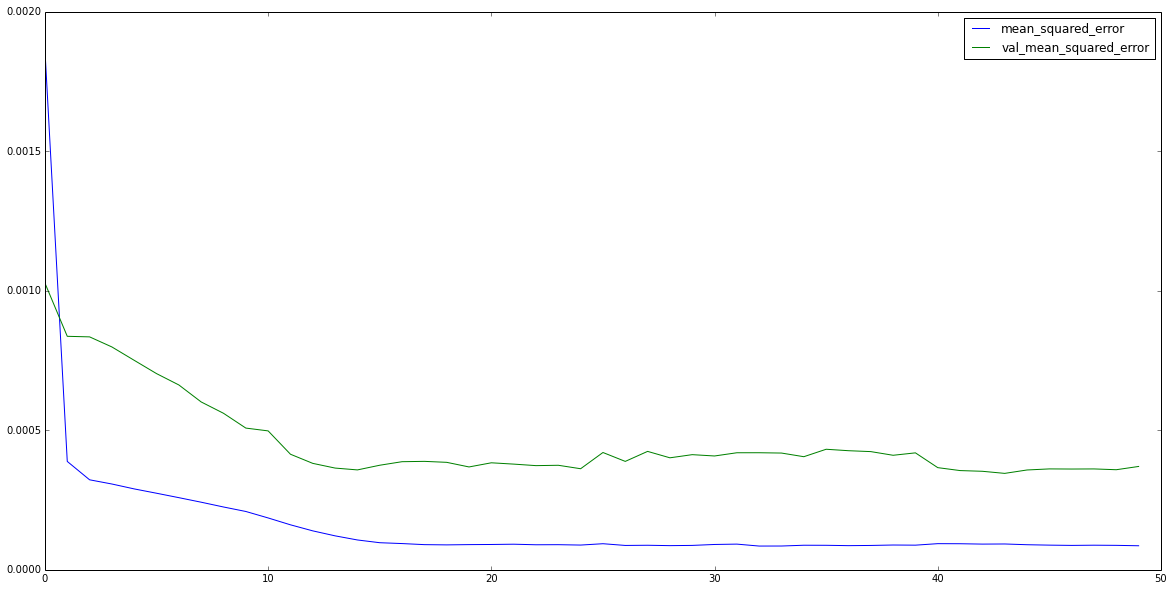

(1656349, 6)
Test RMSE: 40.408


In [9]:
%matplotlib inline

# plot history
pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['acc'], label='acc')
pyplot.plot(history.history['val_acc'], label='val_acc')
pyplot.legend()
pyplot.show()

pyplot.figure(figsize=(20,10))
pyplot.plot(history.history['mean_squared_error'], label='mean_squared_error')
pyplot.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
#3d to 2d conversion
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:,  -(n_features-1):]), axis=1)
inv_yhat_testpoint = concatenate((yhat, test_X[:,  -(n_features-1):]), axis=1)
print(inv_yhat_testpoint.shape)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -(n_features-1):]), axis=1)#---------
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [10]:
history.history.keys()

['acc',
 'loss',
 'val_mean_squared_error',
 'val_acc',
 'mean_squared_error',
 'val_loss']

In [11]:
inv_y #actual

array([ 383.75      ,  415.75003052,  465.75      , ...,  381.5       ,
        375.        ,  387.        ], dtype=float32)

In [12]:
inv_yhat #forcasted

array([ 369.30615234,  411.96566772,  439.09222412, ...,  383.53503418,
        389.42932129,  377.43881226], dtype=float32)

In [25]:
dataset

,Flow,TimePeriod,AverageJT,AverageSpeed,DataQuality,LinkLength
Date,,,,,,
2015-03-01,31.0,0,138.2500,117.4375,1,4.511719
2015-03-01,32.5,1,138.2500,117.4375,1,4.511719
2015-03-01,26.5,2,138.2500,117.4375,1,4.511719
2015-03-01,23.5,3,138.2500,117.4375,1,4.511719
2015-03-01,18.0,4,138.2500,117.4375,1,4.511719
2015-03-01,17.0,5,150.5000,107.9375,3,4.511719
2015-03-01,16.0,6,159.5000,101.7500,3,4.511719
2015-03-01,13.5,7,158.1250,102.6875,3,4.511719
2015-03-01,11.0,8,164.2500,98.8750,3,4.511719


In [1]:
whos

Interactive namespace is empty.
